## Imports

In [1]:
# Standard Lib
import os
import pickle

# Visualization
import matplotlib.pyplot as plt

# Numerical Analysis
import numpy as np

# Torch
import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.utils.data as data

## Datasets

In [2]:
def simple_normal():
    count = 1000
    rand = np.random.RandomState(0)
    samples = 0.4 + 0.1 * rand.randn(count)
    data = np.digitize(samples, np.linspace(0.0, 1.0, 20))
    split = int(0.8 * len(data))
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

def bimodal_normal():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    data = np.digitize(samples, np.linspace(0.0, 1.0, 100))
    split = int(0.8 * len(data))
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

## Train Loaders

In [3]:
simple_train, simple_test = simple_normal()
simple_train_loader = data.DataLoader(simple_train, batch_size=128, shuffle=True)

bimodal_train, bimodal_test = bimodal_normal()
bimodal_train_loader = data.DataLoader(bimodal_train, batch_size=128, shuffle=True)

## Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

In [4]:
class Hist(nn.Module):
    def __init__(self, d):
        super(Hist, self).__init__()
        self.theta = nn.Parameter(torch.zeros(d), requires_grad=True)
    
    def loss(self, x):
        theta = self.theta.unsqueeze(0).repeat(x.shape[0], 1)
        return F.cross_entropy(theta, x.long())
    
    def distribution(self):
        distribution = F.softmax(self.theta, dim=0)
        return distribution.detach().cpu().numpy()
    
def train(train_loader, d, num_epochs=100):
    device = torch.device("cuda:0")
    hist = Hist(d)
    hist = hist.to(device)
    
    optimizer = optim.SGD(hist.parameters(), lr=0.01, momentum=0.9)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader):
            x = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = hist.loss(x)
            loss.backward()
            optimizer.step()
            
            
    return hist

## Validation

In [5]:
def view_distribution_1d(data, distribution, title):
    d = len(distribution)

    plt.figure()
    plt.hist(data, bins=np.arange(d) - 0.5, label='train data', density=True)

    x = np.linspace(-0.5, d - 0.5, 1000)
    y = distribution.repeat(1000 // d)
    plt.plot(x, y, label='learned distribution')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()

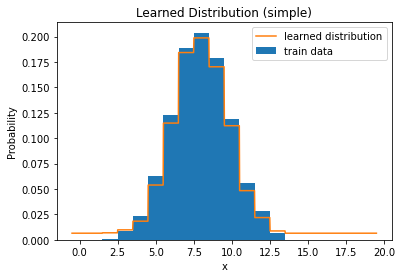

In [6]:
simple_net = train(simple_train_loader, 20)
view_distribution_1d(simple_train, simple_net.distribution(), 'Learned Distribution (simple)')

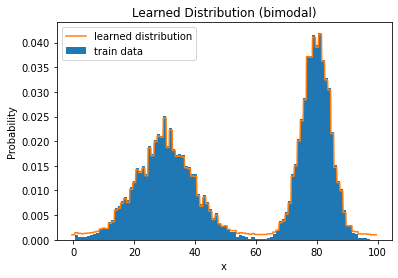

In [7]:
bimodal_net = train(bimodal_train_loader, 100)
view_distribution_1d(bimodal_train, bimodal_net.distribution(), 'Learned Distribution (bimodal)')